Step 1 - Baseline

In [48]:
# Imports

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import contractions
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zephyr.howson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zephyr.howson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
# Download dataset

path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
print("Path to dataset files:", path)
fake_df = pd.read_csv(f"{path}\Fake.csv")
true_df = pd.read_csv(f"{path}\True.csv")

Path to dataset files: C:\Users\zephyr.howson\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\1


In [50]:
# Combine the two datasets with true/fake binary indicator

true_df['true'] = 1
fake_df['true'] = 0
df =  pd.concat([fake_df, true_df], ignore_index = True)

In [51]:
# Drop any duplicates

print(f"Duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

Duplicate rows: 209


In [52]:
# Convert date column and drop invalid dates
    
df['date'] = pd.to_datetime(df['date'], errors='coerce',format='mixed')
print(f"Invalid dates: {df['date'].isnull().sum()}")
df.dropna(subset=['date'], inplace=True)

Invalid dates: 10


In [53]:
# Check for missing values

df.isnull().sum()

title      0
text       0
subject    0
date       0
true       0
dtype: int64

In [54]:
# Subject column

print(f"Subjects: {df['subject'].unique().tolist()}")
print(f"Fake subjects: {df[df['true'] == 0]['subject'].unique().tolist()}")
print(f"True subjects: {df[df['true'] == 1]['subject'].unique().tolist()}")

Subjects: ['News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east', 'politicsNews', 'worldnews']
Fake subjects: ['News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east']
True subjects: ['politicsNews', 'worldnews']


In [55]:
# Create domains
# There are only two subjects for True news, so only 2 domains are created

news_subjects = ['News', 'US_News', 'Middle-east', 'worldnews']
politics_subjects = ['politics', 'Government News', 'left-news', 'politicsNews']

# Create domain column based on subject
def map_domain(subject):
    if subject in news_subjects:
        return 'News'
    elif subject in politics_subjects:
        return 'Politics'
    else:
        return 'Other'

df['domain'] = df['subject'].apply(map_domain)

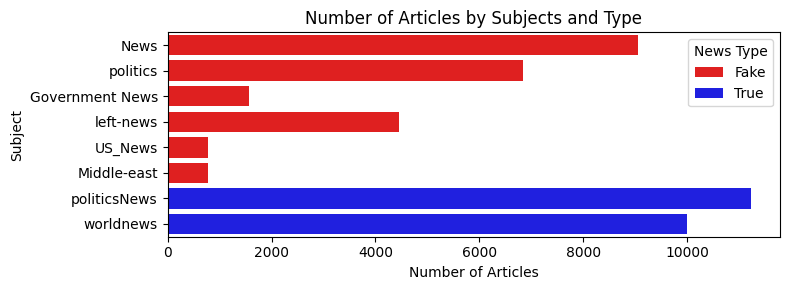

In [56]:
# Bar chart of articles by subjects and type

df['label'] = df['true'].map({0: 'Fake', 1: 'True'})

plt.figure(figsize=(8, 3))  # Wider figure
sns.countplot(y='subject', hue='label', data=df, palette=['red', 'blue'])
plt.title("Number of Articles by Subjects and Type")
plt.legend(title='News Type')
plt.xlabel("Number of Articles")  # Fixed typo
plt.ylabel("Subject")
plt.tight_layout()
plt.show()

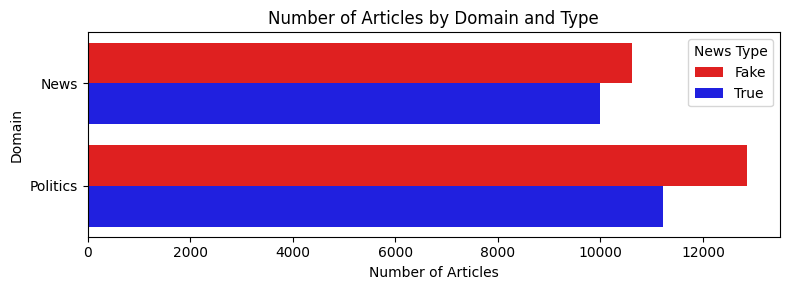

In [57]:
# Bar chart of articles by domain and type

df['label'] = df['true'].map({0: 'Fake', 1: 'True'})

plt.figure(figsize=(8, 3))  # Wider figure
sns.countplot(y='domain', hue='label', data=df, palette=['red', 'blue'])
plt.title("Number of Articles by Domain and Type")
plt.legend(title='News Type')
plt.xlabel("Number of Articles")  # Fixed typo
plt.ylabel("Domain")
plt.tight_layout()
plt.show()

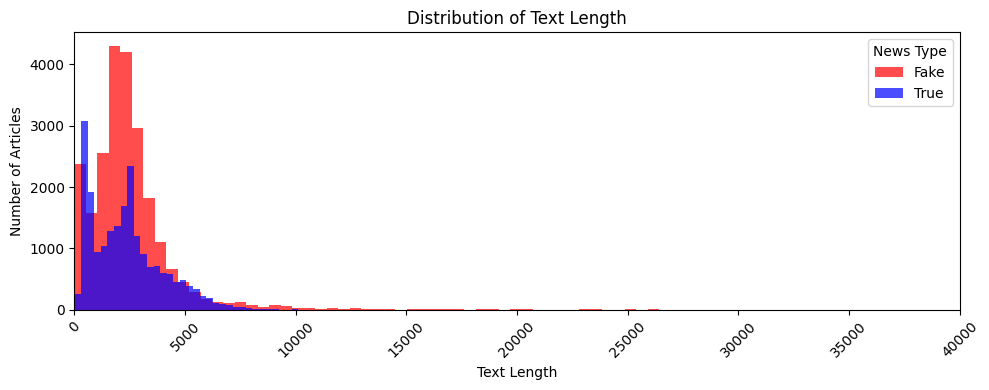

In [58]:
# Histogram of distribution of text length by type

df['length'] = df['text'].str.len()

plt.figure(figsize=(10, 4))  # Wider figure
plt.hist(df[df['true'] == 0]['length'], bins=100, alpha=0.7, label='Fake', color='red')
plt.hist(df[df['true'] == 1]['length'], bins=100, alpha=0.7, label='True', color='blue')
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Number of Articles")
plt.xticks(np.arange(0, 40001, 5000), rotation=45)
plt.xlim(0, 40000)
plt.legend(title='News Type')
plt.tight_layout()
plt.show()

In [59]:
# Clean text function

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    
    text = text.lower()                                      # Make lowercase
    text = contractions.fix(text)                           # Fix contractions
    text = re.sub(r'https?://\S+|www\.\S+', '', text)       # Remove URLs
    text = re.sub(r'<.*?>', '', text)                       # Remove HTML tags
    text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', text)     # Remove brackets and contents
    text = re.sub(r'[\n\t\r]', ' ', text)                   # Remove newlines and tabs
    text = re.sub(r'\S*@\S*\s?', '', text)                  # Remove emails
    text = re.sub(r'\b\w*\d\w*\b', '', text)                # Remove words with numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in STOPWORDS]
    text = ' '.join(words)
    
    # Reduce to base word
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words) 
    
    text = re.sub(r'\s+', ' ', text).strip() # Remove added spaces
    
    return text

In [60]:
# Apply clean text function

df['text_clean'] = (df['title'] + ' ' + df['text']).apply(clean_text)

Evaluating model performance across domains

In [77]:
# Split data and convert into matrix of TF-IDF features

x = df[['text_clean', 'domain']]
y = df[['true', 'domain']]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.25, stratify=y)

vector = TfidfVectorizer()
xv_train = vector.fit_transform(x_train['text_clean'])
xv_test = vector.transform(x_test['text_clean'])

In [78]:
# Train models

# Model 1
log_model=LogisticRegression()
log_model.fit(xv_train,y_train['true']) 

# Model 2
tree_model = DecisionTreeClassifier()
tree_model.fit(xv_train,y_train['true'])

# Model 3
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
xgb_model.fit(xv_train, y_train['true'])

C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:40:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [81]:
# Function to evaluate model performance

def evaluate_model(name, model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(f'{name} Evaluation')
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
    print(ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues'))

Logistic Regression Evaluation
Accuracy: 0.9828
Precision: 0.9779
Recall: 0.9860
F1 Score: 0.9820


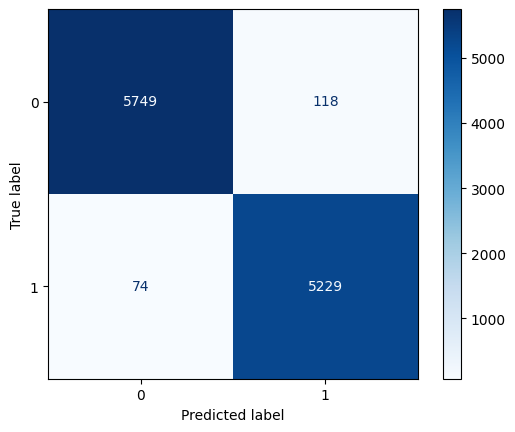

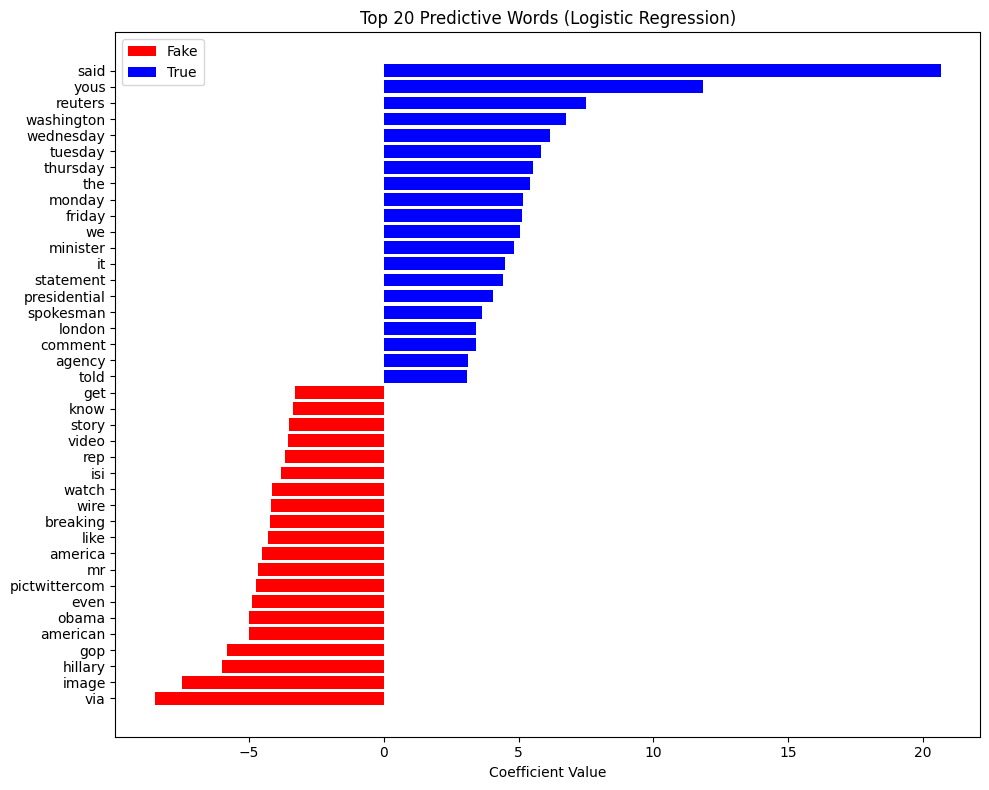

In [82]:
# Evaluate model 1 (Logistic Regression)

# Performance metrics
evaluate_model("Logistic Regression", log_model, xv_test, y_test['true'])

# Plot importance of features
feature_names = np.array(vector.get_feature_names_out())
coef = log_model.coef_[0]  
top_pos = np.argsort(coef)[-20:]
top_neg = np.argsort(coef)[:20]
plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_neg], coef[top_neg], color='red', label='Fake')
plt.barh(feature_names[top_pos], coef[top_pos], color='blue', label='True')
plt.title(f"Top 20 Predictive Words (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.legend()
plt.tight_layout()
plt.show()

Decision Tree Evaluation
Accuracy: 0.9465
Precision: 0.9472
Recall: 0.9397
F1 Score: 0.9434


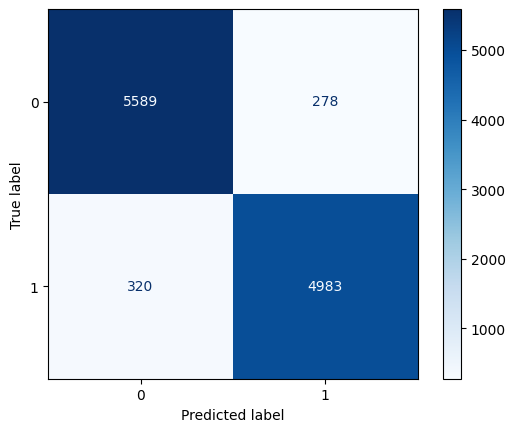

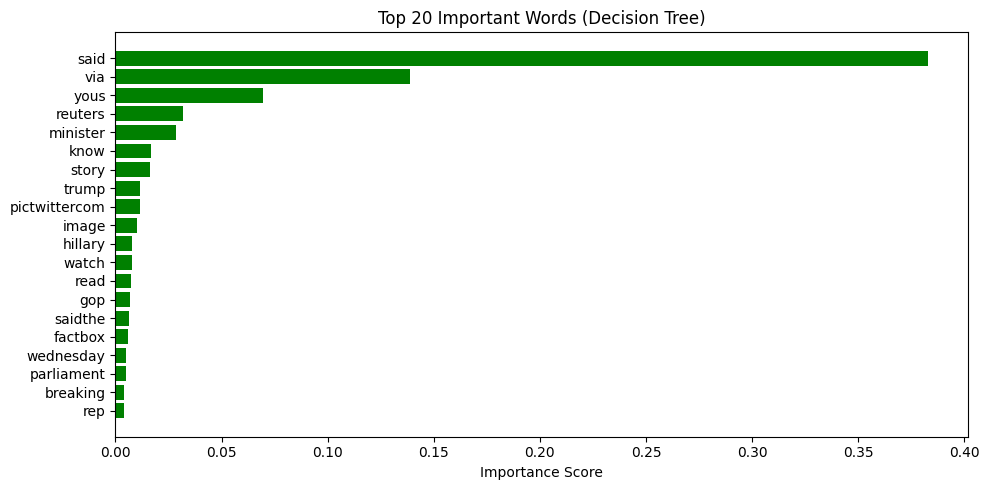

In [83]:
# Evaluate model 2 (Decision Tree)

# Performance metrics
evaluate_model("Decision Tree", tree_model, xv_test, y_test['true'])

# Plot importance of features
feature_names = vector.get_feature_names_out()
importances = tree_model.feature_importances_
indices = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(np.array(feature_names)[indices], importances[indices], color='green')
plt.title(f"Top 20 Important Words (Decision Tree)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

XGBoost Evaluation
Accuracy: 0.9908
Precision: 0.9900
Recall: 0.9906
F1 Score: 0.9903


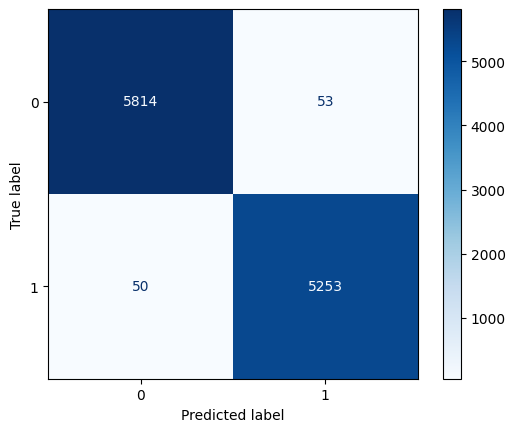

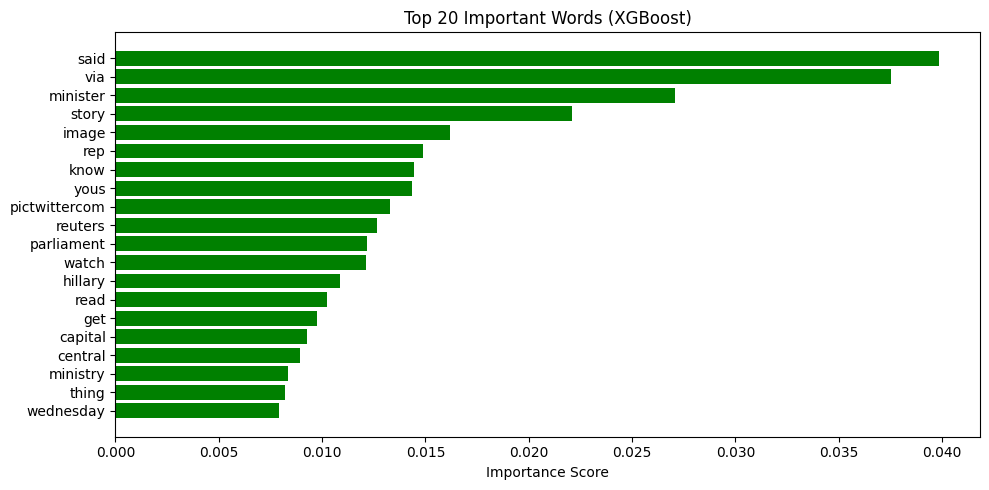

In [84]:
# Evaluate model 3 (XGBoost)

# Performance metrics
evaluate_model("XGBoost", xgb_model, xv_test, y_test['true'])

# Plot importance of features
feature_names = vector.get_feature_names_out()
importances = xgb_model.feature_importances_
top_idx = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(feature_names[top_idx], importances[top_idx], color='green')
plt.title("Top 20 Important Words (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Evaluating model performance within domains

In [85]:
# Functrion for evaluating model by domain

def evaluate_model_by_domain(name, model):
    
    for domain in df['domain'].unique():
        
        print(f"{name} for domain: {domain}")
        x_domain = x_test[x_test['domain'] == domain]['text_clean']
        y_domain = y_test[y_test['domain'] == domain]['true']
        xv_domain = vector.transform(x_domain)
        y_pred_domain = model.predict(xv_domain)  # or any model
        
        print(f'Accuracy: {accuracy_score(y_domain, y_pred_domain):.4f}')
        print(f'Precision: {precision_score(y_domain, y_pred_domain):.4f}')
        print(f'Recall: {recall_score(y_domain, y_pred_domain):.4f}')
        print(f'F1 Score: {f1_score(y_domain, y_pred_domain):.4f}\n')

In [86]:
# Evaluate model 1 (Logistic Regression)

evaluate_model_by_domain("Logistic Regression", log_model)

Logistic Regression for domain: News
Accuracy: 0.9917
Precision: 0.9924
Recall: 0.9904
F1 Score: 0.9914

Logistic Regression for domain: Politics
Accuracy: 0.9752
Precision: 0.9653
Recall: 0.9822
F1 Score: 0.9737



In [87]:
# Evaluate model 2 (Decision Tree)

evaluate_model_by_domain("Decision Tree", tree_model)

Decision Tree for domain: News
Accuracy: 0.9526
Precision: 0.9604
Recall: 0.9412
F1 Score: 0.9507

Decision Tree for domain: Politics
Accuracy: 0.9412
Precision: 0.9357
Recall: 0.9383
F1 Score: 0.9370



In [88]:
# Evaluate model 2 (XGBoost)

evaluate_model_by_domain("XGBoost", xgb_model)

XGBoost for domain: News
Accuracy: 0.9942
Precision: 0.9988
Recall: 0.9892
F1 Score: 0.9940

XGBoost for domain: Politics
Accuracy: 0.9879
Precision: 0.9823
Recall: 0.9918
F1 Score: 0.9870



Model selection:

The XGBoost model performs the best in each metric across all domains (accuracy, precision, recall, F1). For each model, the model performs better in the News domain than the Politics domain. As such, the XGBoost model will be used in further analysis.

Step 2 - Improvement (XGBoost model)

In [ ]:
# Hyperparameter tuning for XGBoost

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
search = RandomizedSearchCV(estimator=xgb,
                            param_distributions=param_grid,
                            n_iter=6,
                            cv=3,
                            scoring='f1',
                            verbose=1,
                            n_jobs=1,
                            random_state=1)

search.fit(xv_train, y_train['true'])

best_xgb = search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:45:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:46:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:47:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:48:23] WARNING: C:\actions-runner\_w

In [89]:
# Parameters of the best model

best_xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.4,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 7,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 150,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 1,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1.0,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'use_label_encoder': False}

In [90]:
# Train best model

best_xgb.fit(xv_train, y_train['true'])

C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:43:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, ...)

Best XGBoost Evaluation
Accuracy: 0.9917
Precision: 0.9904
Recall: 0.9921
F1 Score: 0.9912


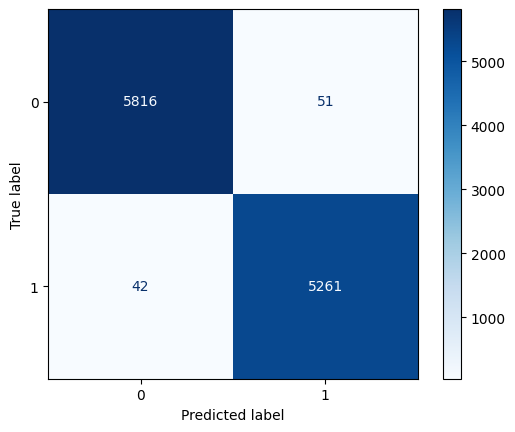

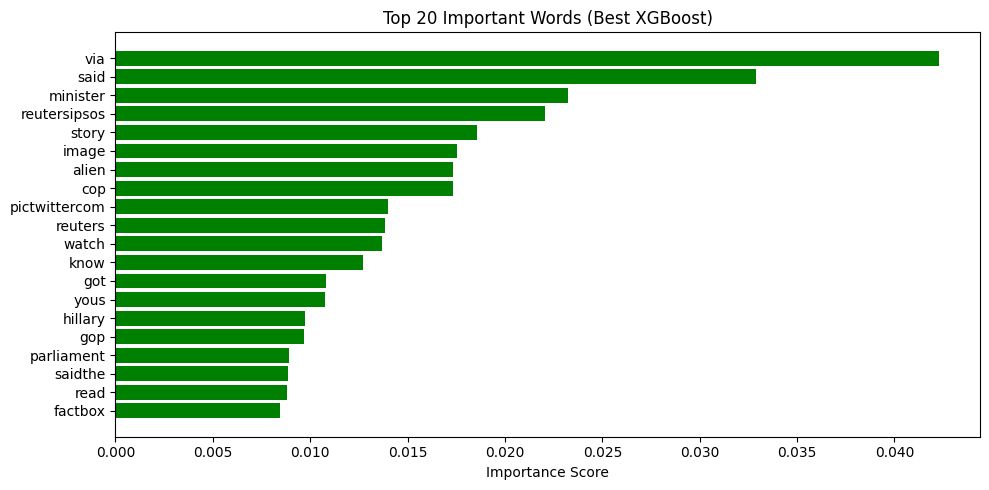

In [91]:
# Evaluate best model

# Performance metrics
evaluate_model("Best XGBoost", best_xgb, xv_test, y_test['true'])

# Plot importance of features
feature_names = vector.get_feature_names_out()
importances = best_xgb.feature_importances_
top_idx = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(feature_names[top_idx], importances[top_idx], color='green')
plt.title("Top 20 Important Words (Best XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [92]:
# Evaluate best model by domain

evaluate_model_by_domain("Best XGBoost", best_xgb)

Best XGBoost for domain: News
Accuracy: 0.9950
Precision: 0.9984
Recall: 0.9912
F1 Score: 0.9948

Best XGBoost for domain: Politics
Accuracy: 0.9889
Precision: 0.9834
Recall: 0.9929
F1 Score: 0.9881



C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:50:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost News Evaluation
Accuracy: 0.9967
Precision: 0.9960
Recall: 0.9972
F1 Score: 0.9966


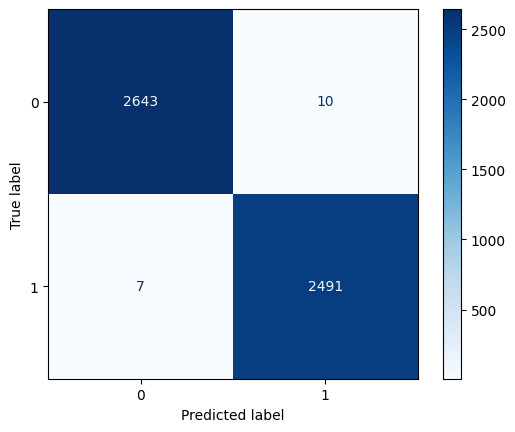

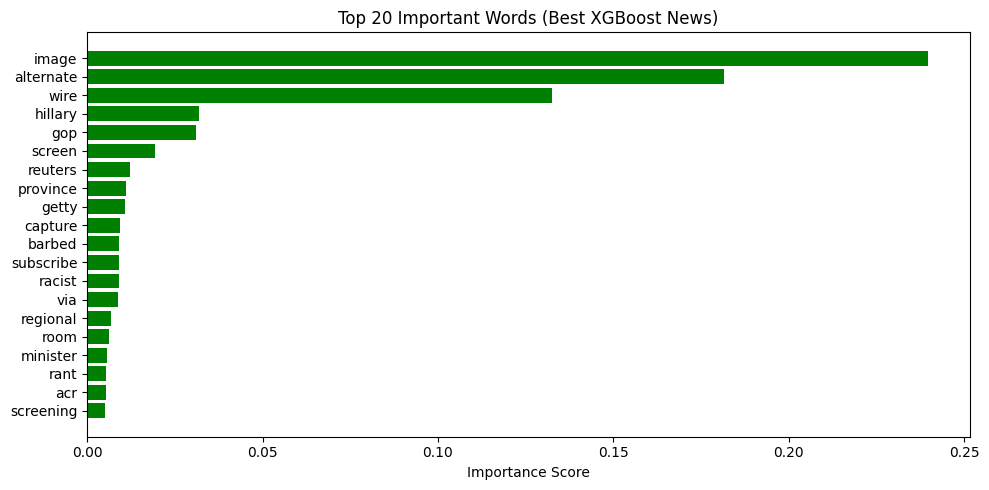

In [95]:
# Run and evaluate the best model on News domain

x_news = df[df['domain'] == "News"]['text_clean']
y_news = df[df['domain'] == "News"]['true']
x_train_news, x_test_news, y_train_news, y_test_news = train_test_split(x_news, y_news, random_state=1, test_size=0.25, stratify=y_news)

vector_news = TfidfVectorizer()
xv_train_news = vector_news.fit_transform(x_train_news)
xv_test_news = vector_news.transform(x_test_news)

best_xgb.fit(xv_train_news, y_train_news)

evaluate_model("Best XGBoost News", best_xgb, xv_test_news, y_test_news)

feature_names = vector_news.get_feature_names_out()
importances = best_xgb.feature_importances_
top_idx = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(feature_names[top_idx], importances[top_idx], color='green')
plt.title("Top 20 Important Words (Best XGBoost News)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

C:\Users\zephyr.howson\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:51:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Politics Evaluation
Accuracy: 0.9870
Precision: 0.9878
Recall: 0.9843
F1 Score: 0.9861


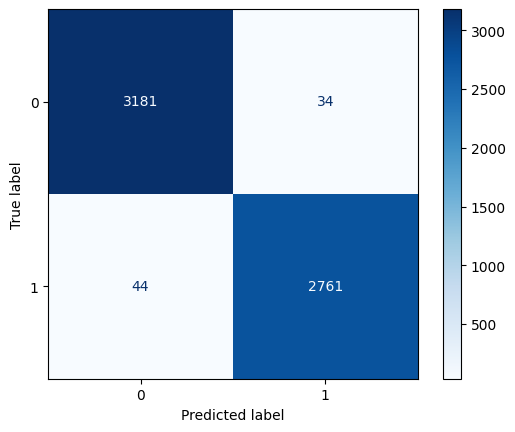

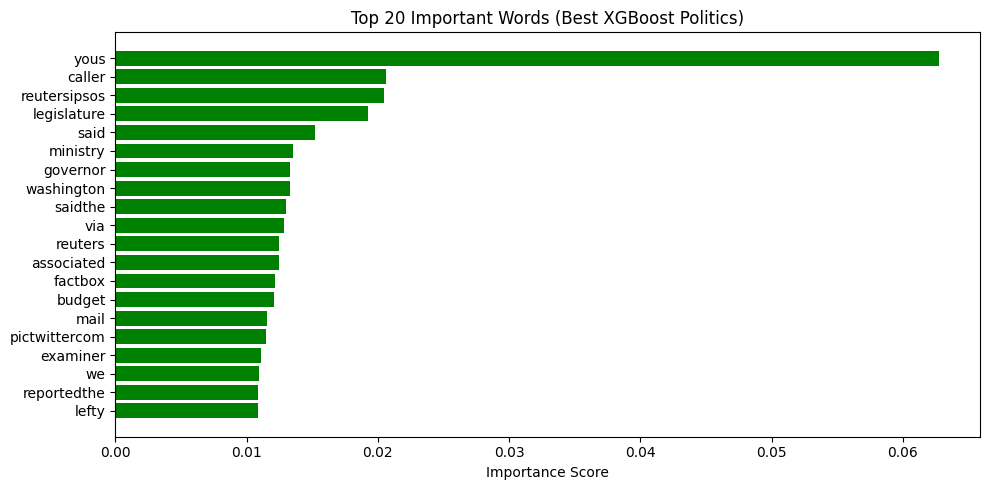

In [96]:
# Run and evaluate the best model on Politics domain

x_pol = df[df['domain'] == "Politics"]['text_clean']
y_pol = df[df['domain'] == "Politics"]['true']
x_train_pol, x_test_pol, y_train_pol, y_test_pol = train_test_split(x_pol, y_pol, random_state=1, test_size=0.25, stratify=y_pol)

vector_pol = TfidfVectorizer()
xv_train_pol = vector_pol.fit_transform(x_train_pol)
xv_test_pol = vector_pol.transform(x_test_pol)

best_xgb.fit(xv_train_pol, y_train_pol)

evaluate_model("Best XGBoost Politics", best_xgb, xv_test_pol, y_test_pol)

feature_names = vector_pol.get_feature_names_out()
importances = best_xgb.feature_importances_
top_idx = np.argsort(importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(feature_names[top_idx], importances[top_idx], color='green')
plt.title("Top 20 Important Words (Best XGBoost Politics)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Best XGBoost model performance:

When run on the entire dataset there was an increase in the metrics, although the base XGBoost model already had high figures. The most important words were 'via', 'said' and 'minister'. The News domain had higher metrics than the Politics domain. The most important words for News were 'image', 'alternate' and 'wire', while the most important words for Politics were 'yous', 'caller' and 'reutersipsos' - potentially some better text cleaning is required...